# Forward modeling tutorial using mosaic images
## Generate simulated spectra

In this tutorial I'll show you how to create 1D and 2D forward modeled grism spectra

In [13]:
from grizli import model
import fsps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import os

## Seaborn is used to make plots look nicer. 
## If you don't have it, you can comment it out and it won't affect the rest of the code
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Using FSPS

[Python-FSPS](http://dfm.io/python-fsps/current/stellarpop_api/) documentation

In [112]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.1, dust_type = 1)

In [3]:
wave, flux = sp.get_spectrum(tage = 2.5, peraa=True)

(-0.1, 4)

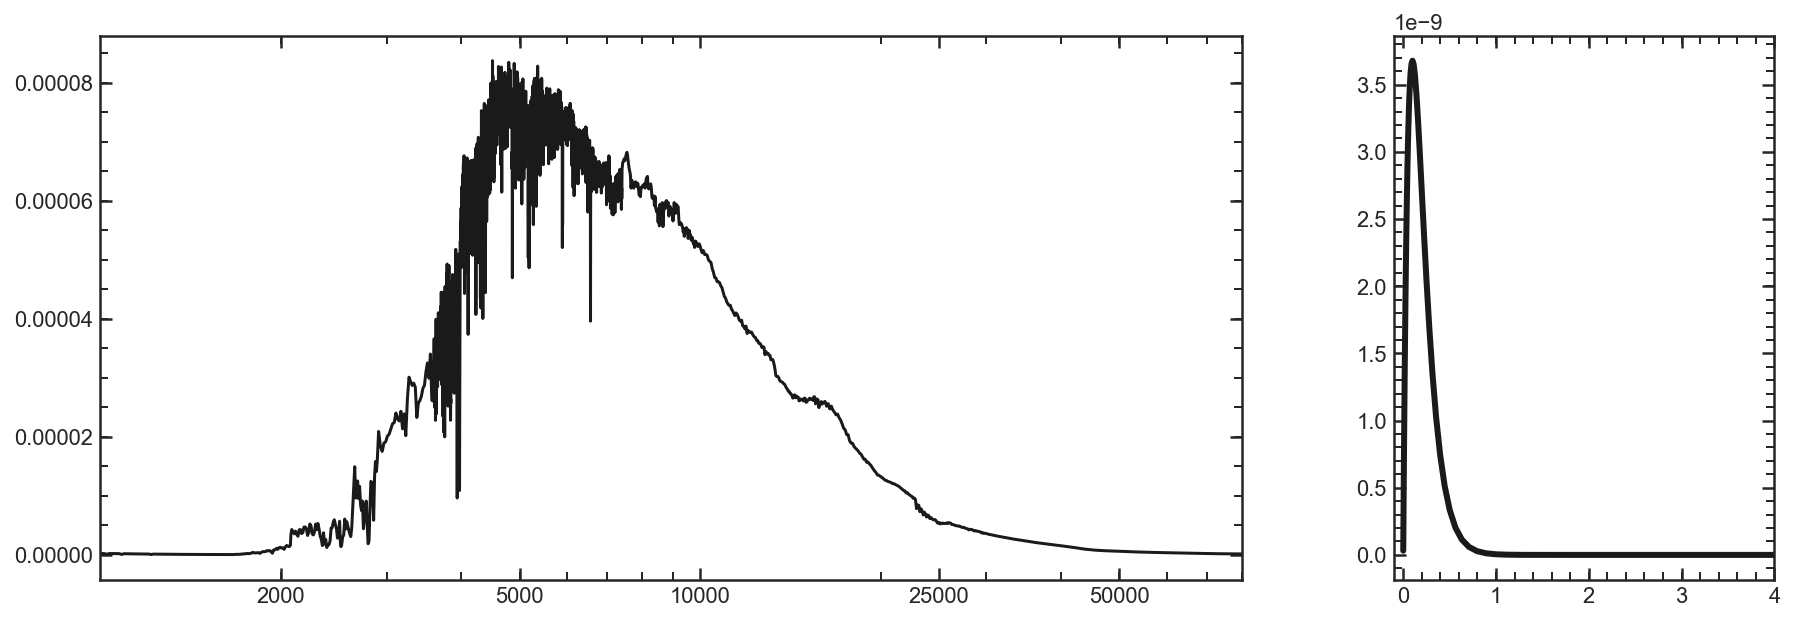

In [24]:
gs = GridSpec(1,2, width_ratios=[3,1])

plt.figure(figsize = [15, 5])
plt.subplot(gs[0])
plt.plot(wave,flux, 'k')
plt.xscale('log')
plt.xticks([2000, 5000, 10000, 25000, 50000],[2000, 5000, 10000, 25000, 50000])
plt.xlim(1000, 80000)

plt.subplot(gs[1])
plt.plot(10**sp.log_age * 1E-9,sp.sfr, 'k', linewidth = 3)
plt.xlim(-0.1,4)

In [72]:
sp.params['logzsol'] = np.log10(0.2)
sp.params['sfh'] = 1
sp.params['tau'] = 0.6
sp.params['dust2'] = 1

In [37]:
wave, flux = sp.get_spectrum(tage = 2.5, peraa=True)

(-0.1, 4)

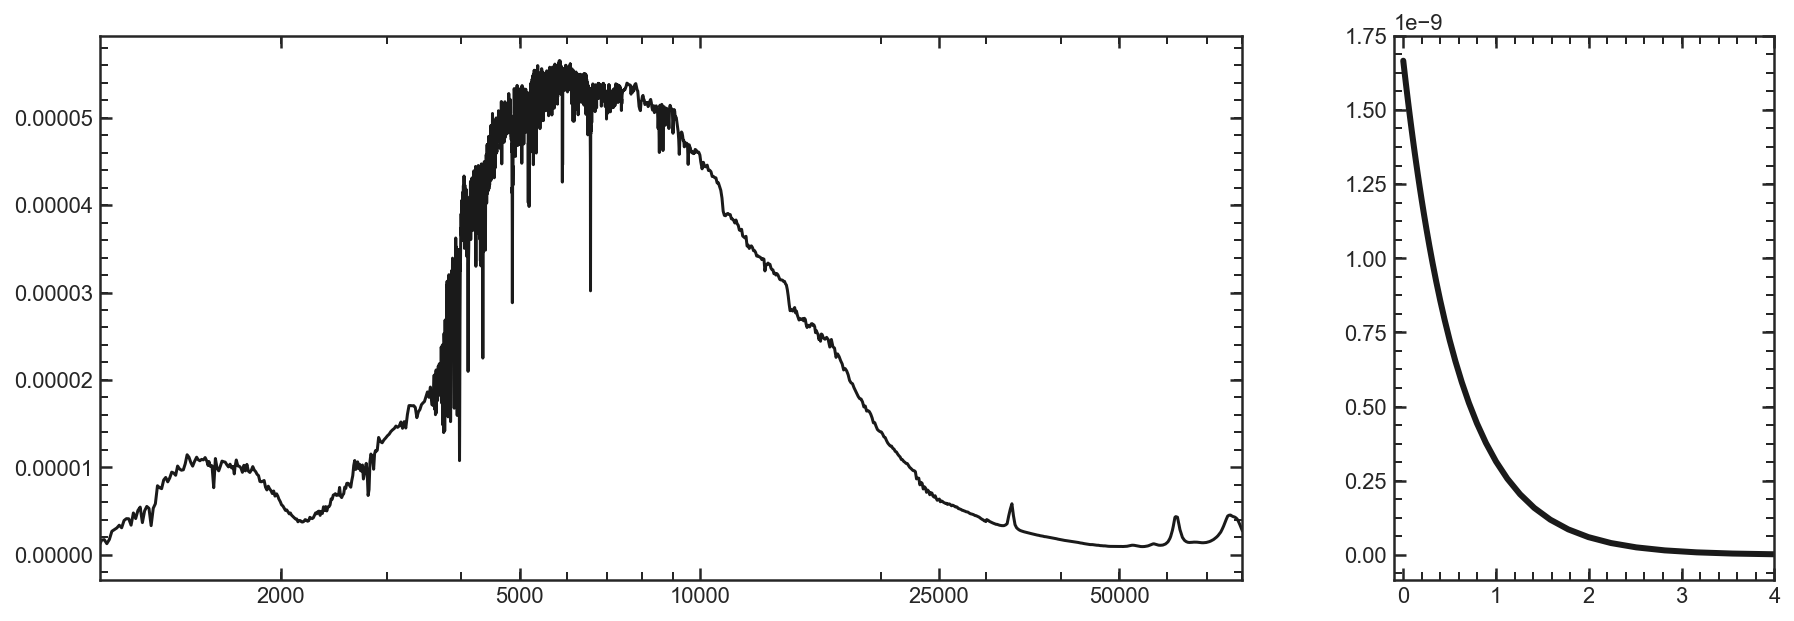

In [41]:
gs = GridSpec(1,2, width_ratios=[3,1])

plt.figure(figsize = [15, 5])
plt.subplot(gs[0])
plt.plot(wave,flux, 'k')
plt.xscale('log')
plt.xticks([2000, 5000, 10000, 25000, 50000],[2000, 5000, 10000, 25000, 50000])
plt.xlim(1000, 80000)

plt.subplot(gs[1])
plt.plot(10**sp.log_age * 1E-9,sp.sfr, 'k', linewidth = 3)
plt.xlim(-0.1,4)

In [113]:
sp.params['add_neb_emission']=1

sp.params['sfh'] = 1
sp.params['tau'] = 0.6
sp.params['logzsol'] = -1.0
sp.params['gas_logz'] = -1.0
sp.params['gas_logu'] = -2.5
sp.params['dust_type'] = 2
sp.params['dust1'] = 0
sp.params['dust2'] = 1.0

In [110]:
wave, flux = sp.get_spectrum(tage=0.5, peraa=True)

(-0.1, 4)

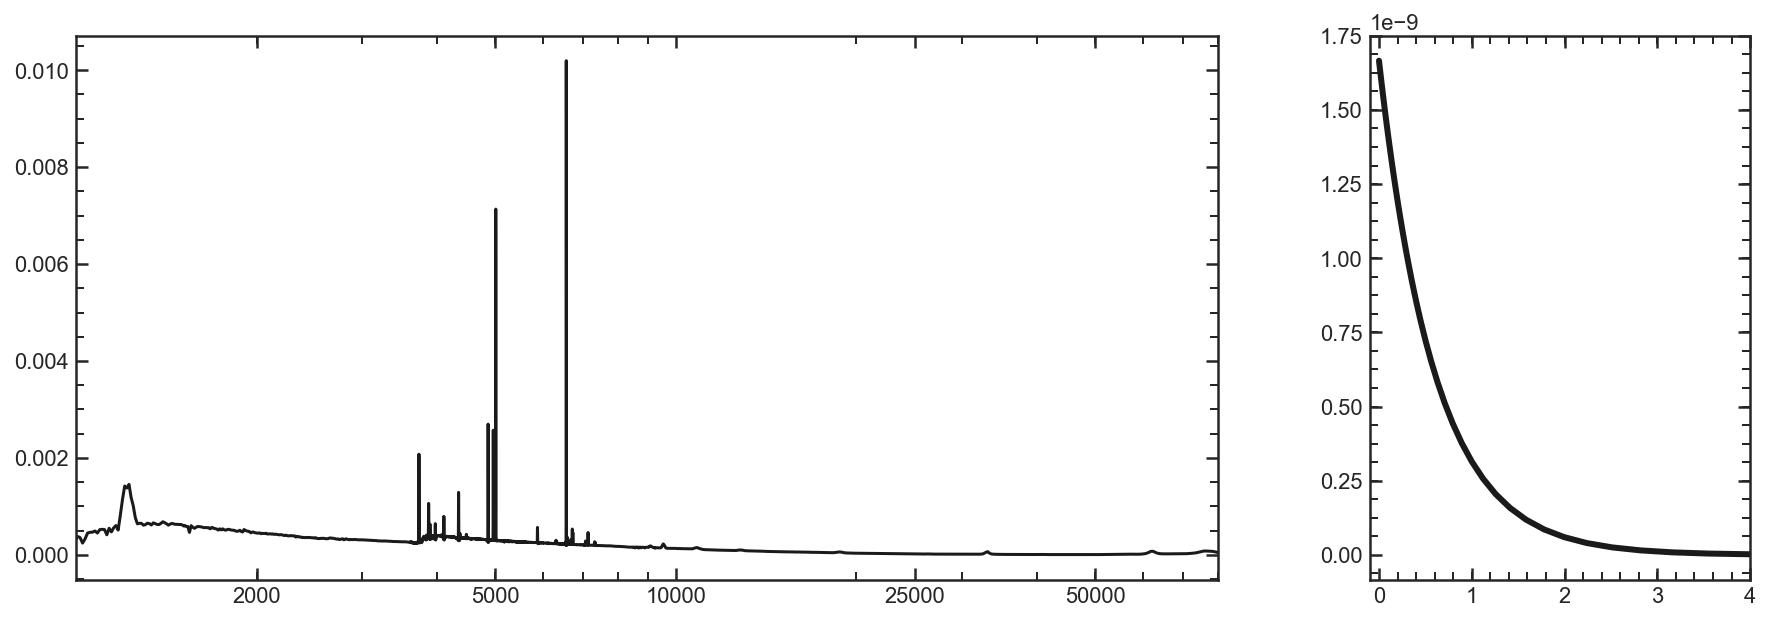

In [114]:
gs = GridSpec(1,2, width_ratios=[3,1])

plt.figure(figsize = [15, 5])
plt.subplot(gs[0])
plt.plot(wave,flux, 'k')
plt.xscale('log')
plt.xticks([2000, 5000, 10000, 25000, 50000],[2000, 5000, 10000, 25000, 50000])
plt.xlim(1000, 80000)

plt.subplot(gs[1])
plt.plot(10**sp.log_age * 1E-9,sp.sfr, 'k', linewidth = 3)
plt.xlim(-0.1,4)

## Read in BeamCutout

By saving out all the BeamCutouts from the previous tutorial [Extract_beam](https://github.com/ivastar/clear/blob/master/notebooks/forward_modeling/Extract_beam.ipynb)
we can skip straight to the cutout object.

In [123]:
g102_48_co = model.BeamCutout(fits_file='48_39170.g102.A.fits')
g102_78_co = model.BeamCutout(fits_file='78_39170.g102.A.fits')
g102_98_co = model.BeamCutout(fits_file='98_39170.g102.A.fits')
g141_co = model.BeamCutout(fits_file='345_39170.g141.A.fits')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


## Generate flat

Here I create a flat model to remove the transmission curve from the final 1D product.

In [124]:
g102_48_flat = g102_48_co.flat_flam.reshape(g102_48_co.beam.sh_beam)
g102_78_flat = g102_78_co.flat_flam.reshape(g102_78_co.beam.sh_beam)
g102_98_flat = g102_98_co.flat_flam.reshape(g102_98_co.beam.sh_beam)
g141_flat = g141_co.flat_flam.reshape(g141_co.beam.sh_beam)

## ffl will be our transmission curve
g102_48_fwv, g102_48_ffl, g102_e = g102_48_co.beam.optimal_extract(g102_48_flat, bin=0)
g102_78_fwv, g102_78_ffl, g102_e = g102_78_co.beam.optimal_extract(g102_78_flat, bin=0)
g102_98_fwv, g102_98_ffl, g102_e = g102_98_co.beam.optimal_extract(g102_98_flat, bin=0)

g141_fwv, g141_ffl, g141_e = g141_co.beam.optimal_extract(g141_flat, bin=0)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


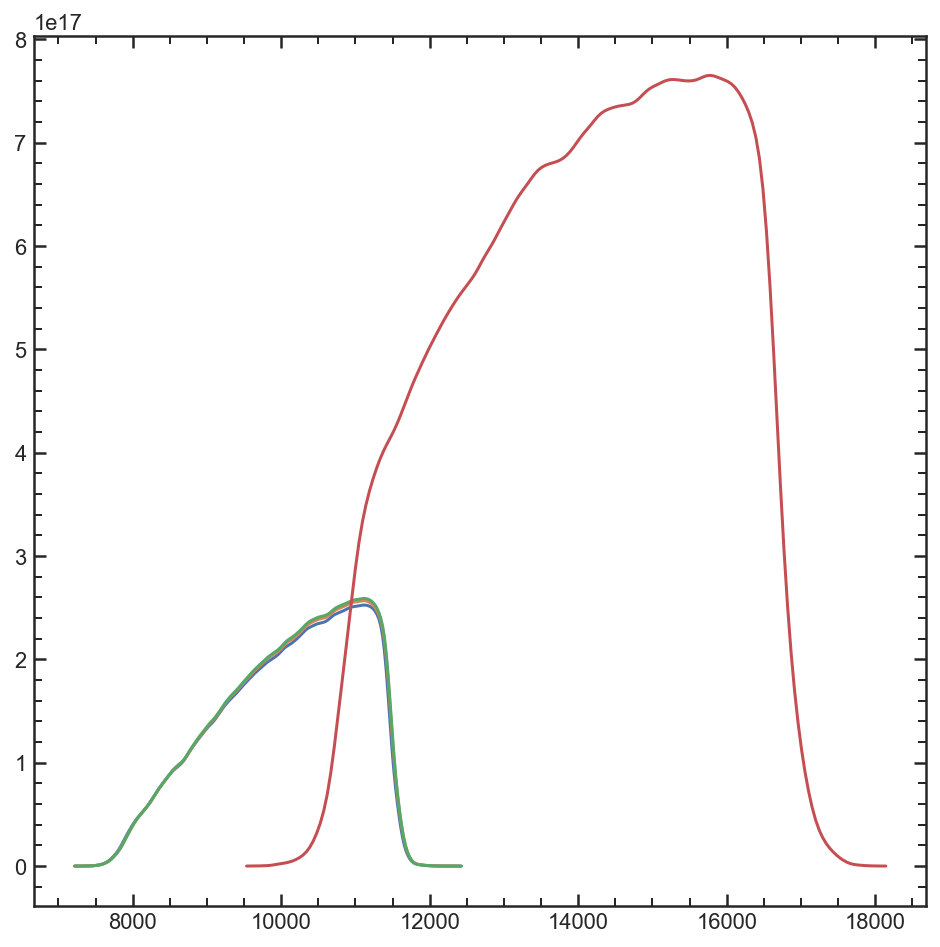

In [118]:
plt.figure(figsize=[8,8])
plt.plot(g102_48_fwv, g102_48_ffl)
plt.plot(g102_78_fwv, g102_78_ffl)
plt.plot(g102_98_fwv, g102_98_ffl)
plt.plot(g141_fwv, g141_ffl)

## Redshift and Forward model

compute_model will generate the 2D model using your model spectra. Here I've redshifted the spectra out to z=1.249 to match the galaxy.

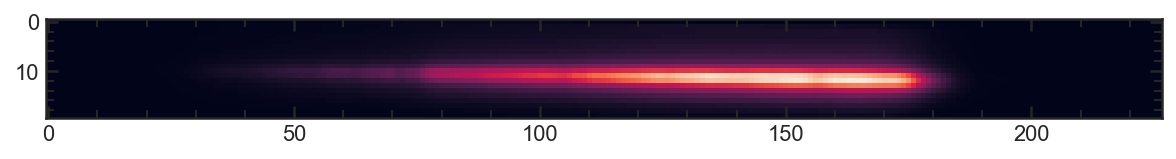

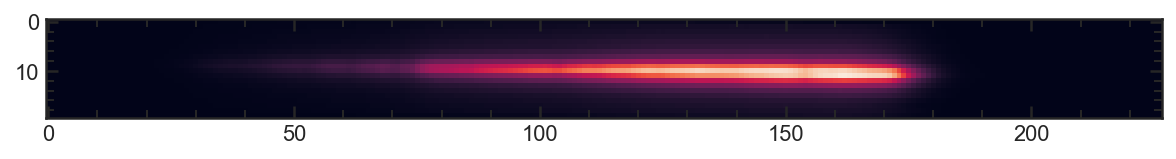

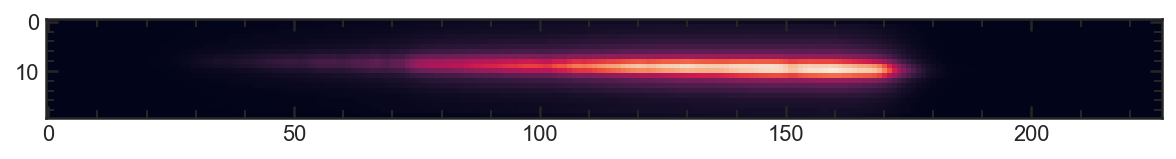

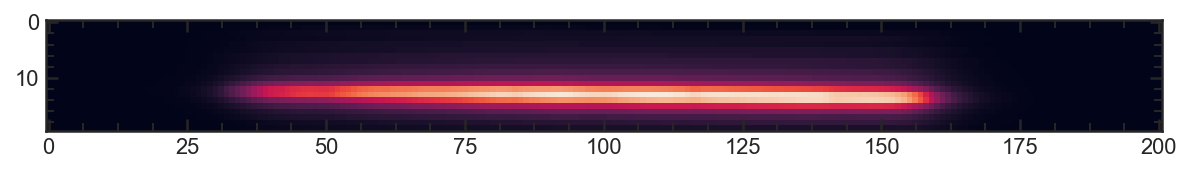

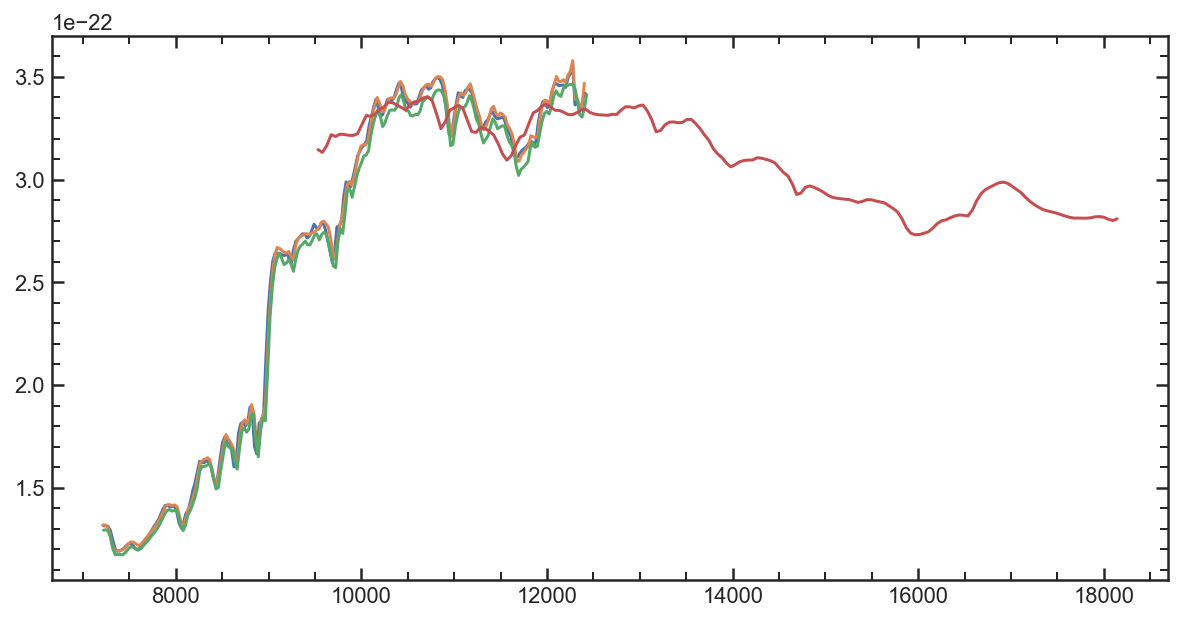

In [125]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.1, dust_type = 1)
wave, flux = sp.get_spectrum(tage = 2.5, peraa=True)

g102_48_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.25), flux])
g102_78_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.25), flux])
g102_98_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.25), flux])
g141_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.25), flux])

g102_48_w, g102_48_f, e = g102_48_co.beam.optimal_extract(g102_48_co.beam.model, bin=0)
g102_78_w, g102_78_f, e = g102_78_co.beam.optimal_extract(g102_78_co.beam.model, bin=0)
g102_98_w, g102_98_f, e = g102_98_co.beam.optimal_extract(g102_98_co.beam.model, bin=0)

g141_w, g141_f, e = g141_co.beam.optimal_extract(g141_co.beam.model, bin=0)

## plot the spectra
plt.figure(figsize=[10,5])
plt.imshow(g102_48_co.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(g102_78_co.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(g102_98_co.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(g141_co.beam.model)

plt.figure(figsize=[10,5])
plt.plot(g102_48_w, g102_48_f / g102_48_ffl)
plt.plot(g102_78_w, g102_78_f / g102_78_ffl)
plt.plot(g102_98_w, g102_98_f / g102_98_ffl)

plt.plot(g141_w, g141_f / g141_ffl)

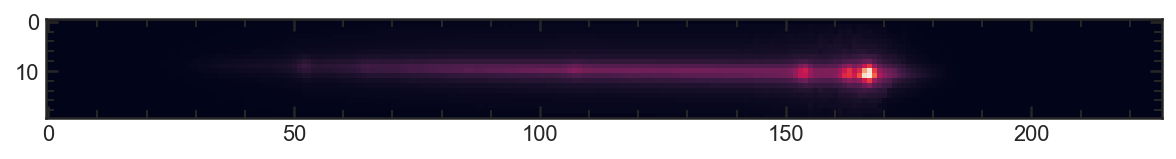

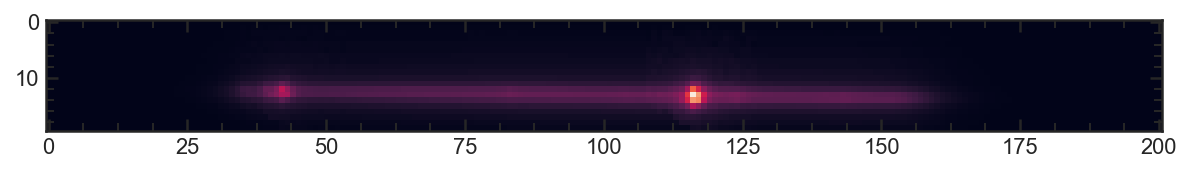

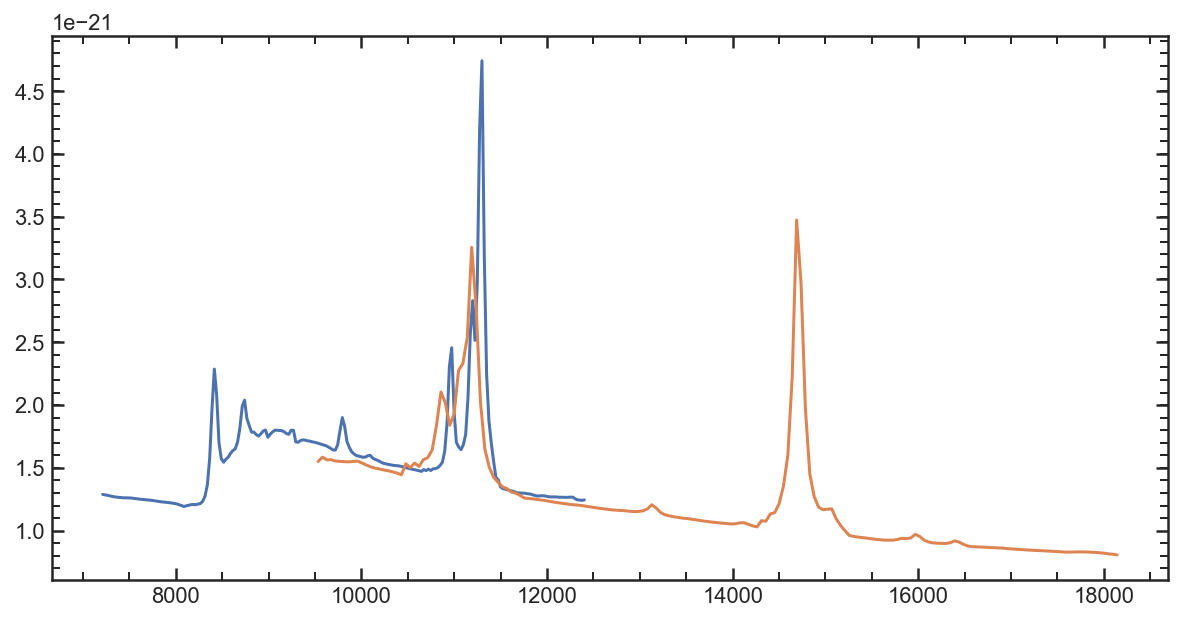

In [107]:
sp.params['add_neb_emission']=1

sp.params['sfh'] = 1
sp.params['tau'] = 0.6
sp.params['logzsol'] = -1.0
sp.params['gas_logz'] = -1.0
sp.params['gas_logu'] = -2.5
sp.params['dust_type'] = 2
sp.params['dust1'] = 0
sp.params['dust2'] = 1.0

wave, flux = sp.get_spectrum(tage = 0.5, peraa=True)

g102_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.25), flux])
g141_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.25), flux])

g102_w, g102_f, e = g102_co.beam.optimal_extract(g102_co.beam.model, bin=0)
g141_w, g141_f, e = g141_co.beam.optimal_extract(g141_co.beam.model, bin=0)

## plot the spectra
plt.figure(figsize=[10,5])
plt.imshow(g102_co.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(g141_co.beam.model)

plt.figure(figsize=[10,5])
plt.plot(g102_w, g102_f / g102_ffl)
plt.plot(g141_w, g141_f / g141_ffl)

# Check model fit for galaxy

In [281]:
def Scale_model(D, sig, M):
    w = 1/sig ** 2
    
    T1 = (D * M * w)
    T2 = (M ** 2 * w)
    
    infmask = np.isinf(T1)
    T1[infmask] = 0

    nanmask = np.isnan(T1)
    T1[nanmask] = 0 

    infmask = np.isinf(T2)
    T2[infmask] = 0

    nanmask = np.isnan(T2)
    T2[nanmask] = 0 
    
    return np.sum(T1) / np.sum(T2)

In [132]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1.4), sfh = 4, tau = 0.48, dust_type = 1)
wave, flux = sp.get_spectrum(tage = 3.42, peraa=True)

g102_48_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.023), flux])
g102_78_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.023), flux])
g102_98_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.023), flux])
g141_co.beam.compute_model(spectrum_1d=[wave * (1 + 1.023), flux])

g102_48_w, g102_48_f, e = g102_48_co.beam.optimal_extract(g102_48_co.beam.model, bin=0)
g102_78_w, g102_78_f, e = g102_78_co.beam.optimal_extract(g102_78_co.beam.model, bin=0)
g102_98_w, g102_98_f, e = g102_98_co.beam.optimal_extract(g102_98_co.beam.model, bin=0)

g141_w, g141_f, e = g141_co.beam.optimal_extract(g141_co.beam.model, bin=0)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


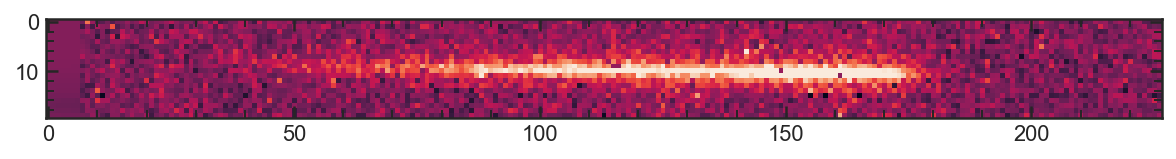

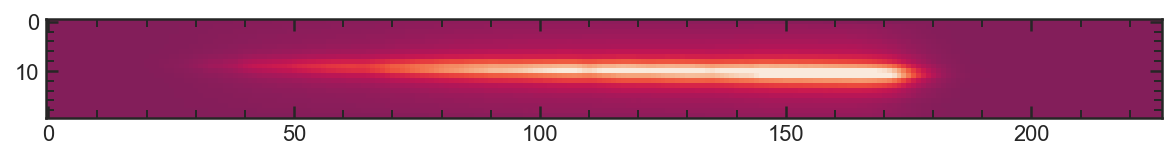

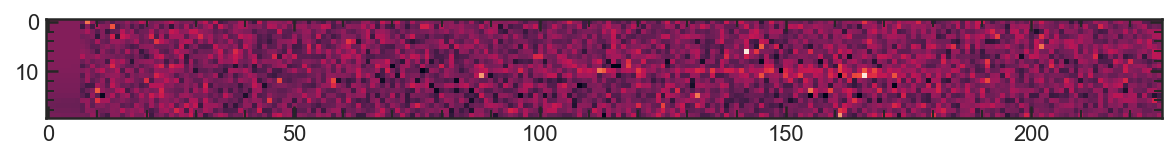

In [282]:
## plot the spectra
g102_beam = model.BeamCutout(fits_file='78_39170.g102.A.fits')

flux_2d = g102_beam.grism.data['SCI'] - g102_beam.contam
err_2d = g102_beam.grism.data['ERR']

scl = Scale_model(flux_2d, err_2d, g102_78_co.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(flux_2d, vmin = -0.1, vmax=0.2)

plt.figure(figsize=[10,5])
plt.imshow(g102_78_co.beam.model * scl, vmin = -0.1, vmax=0.2)

plt.figure(figsize=[10,5])
plt.imshow(flux_2d - scl*g102_78_co.beam.model, vmin = -0.1, vmax=0.2)

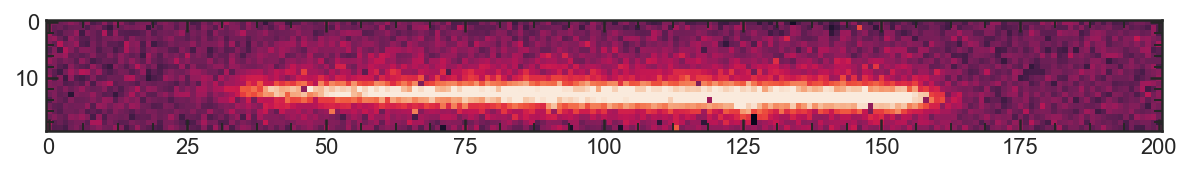

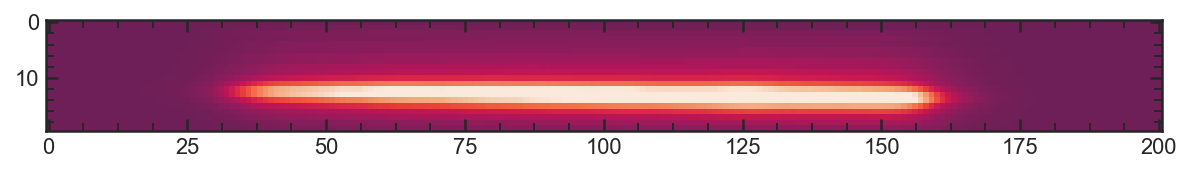

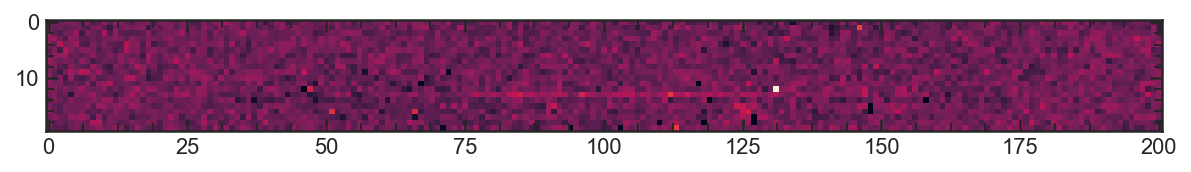

In [283]:
g141_beam = model.BeamCutout(fits_file='345_39170.g141.A.fits')

flux_2d = g141_beam.grism.data['SCI']- g141_beam.contam
err_2d = g141_beam.grism.data['ERR']

scl = Scale_model(flux_2d, err_2d, g141_co.beam.model)

plt.figure(figsize=[10,5])
plt.imshow(flux_2d, vmin = -0.2, vmax=0.5)

plt.figure(figsize=[10,5])
plt.imshow(g141_co.beam.model * scl, vmin = -0.2, vmax=0.5)


plt.figure(figsize=[10,5])
plt.imshow(flux_2d - scl*g141_co.beam.model, vmin = -0.2, vmax=0.5)

In [275]:
D = flux_2d
M = g102_78_co.beam.model
sig = err_2d

w = 1/sig ** 2

T1 = (D * M * w)
T2 = (M ** 2 * w)

infmask = np.isinf(T1)
T1[infmask] = 0

nanmask = np.isnan(T1)
T1[nanmask] = 0 

infmask = np.isinf(T2)
T2[infmask] = 0

nanmask = np.isnan(T2)
T2[nanmask] = 0 

print(np.sum(T1))
print(np.sum(T2))
print(np.sum(T1) / np.sum(T2))

0.8875427506196008
6.15733102169343e-05
14414.406948280375


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [268]:
infmask = np.isinf(T1)
T1[infmask] = 0

nanmask = np.isnan(T1)
T1[nanmask] = 0  

In [269]:
np.sum(T1)

0.8875427506196008

In [207]:
D[~infmask]

array([-6.9703696e-05, -8.6250177e-05, -1.0519588e-04, ...,
       -2.0878782e-02,  1.2535782e-02,  2.7719827e-02], dtype=float32)

In [254]:
scl = np.linspace(1.4E4,2E4)

res = []
for s in scl:
    res.append(np.sum((flux_2d - s*g141_co.beam.model)**2))

[17306.12244898]


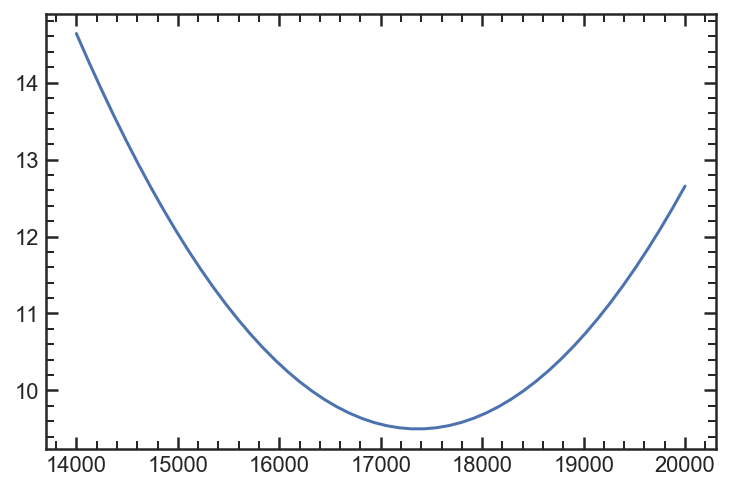

In [255]:
plt.plot(scl, res)
print(scl[res == min(res)])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


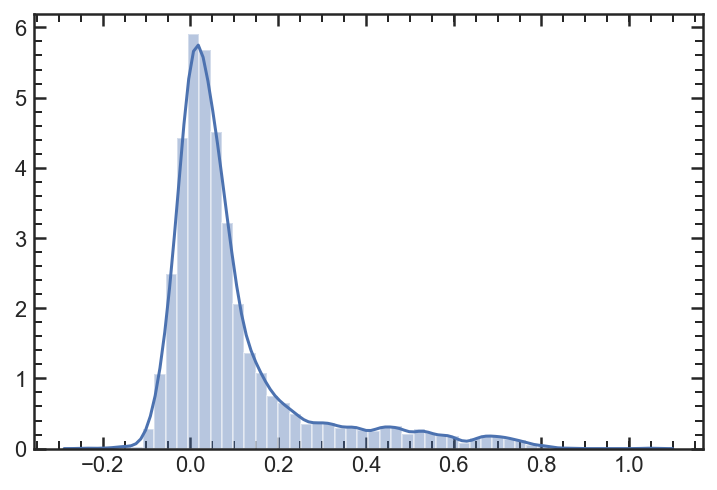

In [242]:
sea.distplot(flux_2d.ravel())